# Ball Challenge

In [1]:


import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torch
import functools
from utils import PositionPrediction

plt.style.use("seaborn-v0_8-whitegrid")

from elasticai.creator.file_generation.on_disk_path import OnDiskPath
from elasticai.creator.vhdl.system_integrations.firmware_env5 import FirmwareENv5

experiment = PositionPrediction()

## Load Training and Test Data

In [2]:

experiment.load_dataset()

print("Train Samples:", len(experiment.train_set))
print("Test Samples:", len(experiment.test_set))

print("Sample Shape:", experiment.input_shape)

Train Samples: 43
Test Samples: 14
Sample Shape: (3, 250)


## Create Model

In [14]:
def conv(in_channels, out_channels, kernel_size):
    return nn.Sequential(nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size),
                         nn.BatchNorm1d(num_features=out_channels),
                         nn.Sigmoid())

experiment.model = nn.Sequential(
    conv(3, 3, kernel_size=64),
    conv(3, 2, kernel_size=26),
    conv(2, 2, kernel_size=13),
    conv(2, 1, kernel_size=13),
    nn.Flatten(),
    nn.Linear(in_features=138, out_features=2)
)


## Train Model

In [15]:
experiment.train(epochs=500)

epoch: 0, train loss: 0.8510292172431946, test loss: 0.7762436057840075
epoch: 1, train loss: 0.8351225852966309, test loss: 0.7674818528550011
epoch: 2, train loss: 0.8193816542625427, test loss: 0.7585556762559074
epoch: 3, train loss: 0.8038164973258972, test loss: 0.7494822506393705
epoch: 4, train loss: 0.7884361147880554, test loss: 0.7402800619602203
epoch: 5, train loss: 0.773249089717865, test loss: 0.7309746742248535
epoch: 6, train loss: 0.758264422416687, test loss: 0.7215793281793594
epoch: 7, train loss: 0.7434905171394348, test loss: 0.7121067409004483
epoch: 8, train loss: 0.728936493396759, test loss: 0.7025683096476963
epoch: 9, train loss: 0.7146106958389282, test loss: 0.6929841978209359
epoch: 10, train loss: 0.7005212903022766, test loss: 0.6833617963961193
epoch: 11, train loss: 0.6866759657859802, test loss: 0.6737179309129715
epoch: 12, train loss: 0.6730812191963196, test loss: 0.6640599178416389
epoch: 13, train loss: 0.6597431302070618, test loss: 0.65439679

## Training History and Distance from predicted positions

mean distance between predicted and actual position  0.6556911266275814


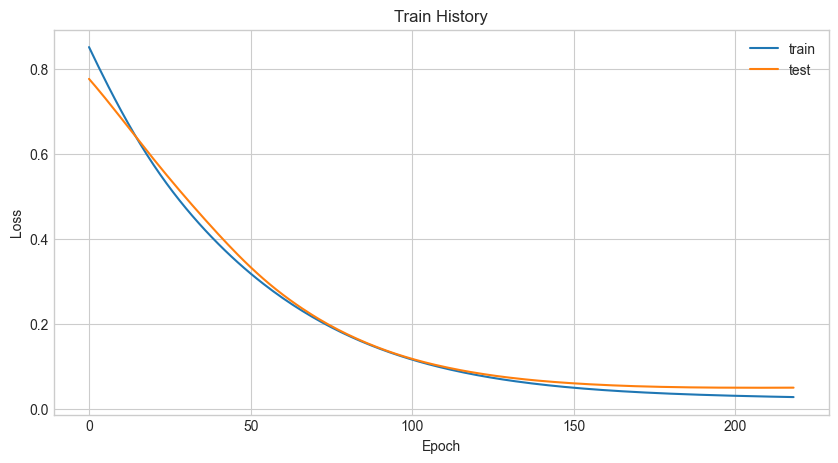

In [18]:
experiment.plot_history()
print("mean distance between predicted and actual position ", experiment.get_mean_and_var_distance_for_test()[0], " meters")

## Save Hardware Implementation

In [5]:
def save_hw_implementation()
    path = OnDiskPath("build")

    hw_design = experiment.model.create_design("ball_throw")

    channels, signal_length = experiment.input_shape
    total_length = channels * signal_length

    firmware = FirmwareENv5(
        network=hw_design,
        x_num_values=total_length,
        y_num_values=2,
        skeleton_version="v2",
        id=666
    )
    firmware.save_to(path)
    hw_design.save_to(path)

AttributeError: 'Sequential' object has no attribute 'create_design'

## Additional Section

### Mean Label of the Dataset